In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [8]:
TRAIN_IMAGES_PATH = '/kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/train_images'
TEST_IMAGES_PATH = '/kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/test_images'
TRAIN_CSV = '/kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/train.csv'
TEST_CSV = '/kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/test.csv'

# Load metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [9]:
print(f"📊 Training samples: {len(train_df)}")
print(f"📊 Test samples: {len(test_df)}")
print(f"📁 Training images folder: {len(os.listdir(TRAIN_IMAGES_PATH))} files")
print(f"📁 Test images folder: {len(os.listdir(TEST_IMAGES_PATH))} files")

📊 Training samples: 2827
📊 Test samples: 707
📁 Training images folder: 2827 files
📁 Test images folder: 707 files


In [10]:
# Analyze dataset structure
print("🔍 Training DataFrame Info:")
print(train_df.head())
print("\n📋 Columns:", train_df.columns.tolist())
print("\n📊 ECO Volume Distribution:")
eco_counts = train_df['eco_volume'].value_counts().sort_index()
print(eco_counts)
print(f"\n🎯 Number of classes: {train_df['eco_volume'].nunique()}")
print(f"📝 Classes: {sorted(train_df['eco_volume'].unique())}")

🔍 Training DataFrame Info:
      image_id eco_volume                                       opening_name  \
0  train_00000          C                       Latvian Gambit: Mayet Attack   
1  train_00001          C  Italian Game: Classical Variation, Giuoco Pian...   
2  train_00002          B             Scandinavian Defense: Lasker Variation   
3  train_00003          C                French Defense: Classical Variation   
4  train_00004          B  Sicilian Defense: O'Kelly Variation, Maróczy Bind   

                                                 pgn  
0                          1. e4 e5 2. Nf3 f5 3. Bc4  
1  1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. c3 Nf6 5. d3 d6  
2  1. e4 d5 2. exd5 Qxd5 3. Nc3 Qa5 4. d4 Nf6 5. ...  
3  1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. Bg5 Be7 5. e5 ...  
4                           1. e4 c5 2. Nf3 a6 3. c4  

📋 Columns: ['image_id', 'eco_volume', 'opening_name', 'pgn']

📊 ECO Volume Distribution:
eco_volume
A    591
B    595
C    960
D    424
E    257
Name: count, dty

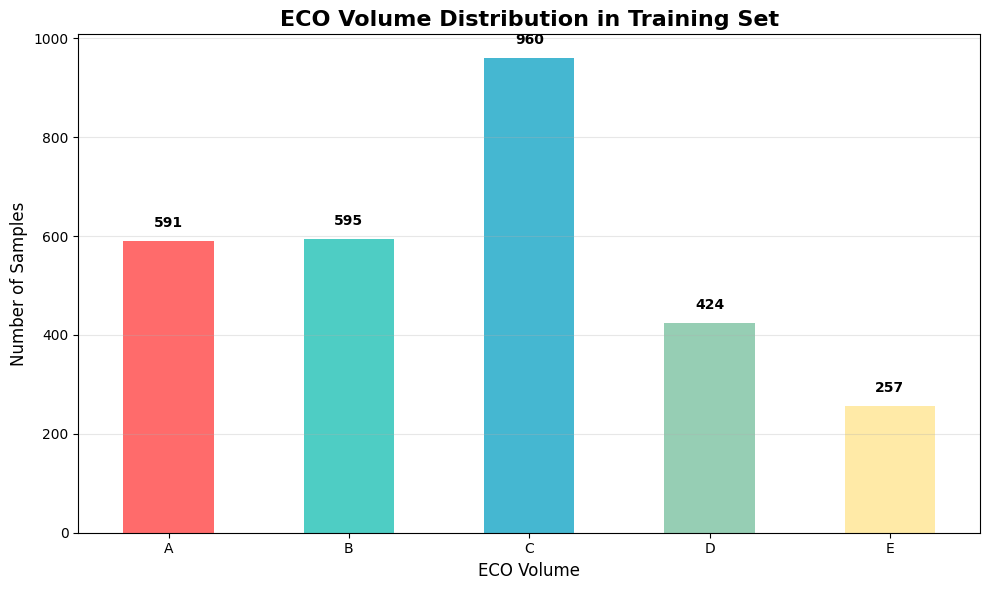


⚖️ Class imbalance ratio: 3.74
⚠️ Significant class imbalance detected - consider weighted loss or data balancing


In [11]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
eco_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.title('ECO Volume Distribution in Training Set', fontsize=16, fontweight='bold')
plt.xlabel('ECO Volume', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(eco_counts.values):
    plt.text(i, v + len(train_df) * 0.01, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = eco_counts.max() / eco_counts.min()
print(f"\n⚖️ Class imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected - consider weighted loss or data balancing")
else:
    print("✅ Classes are reasonably balanced")

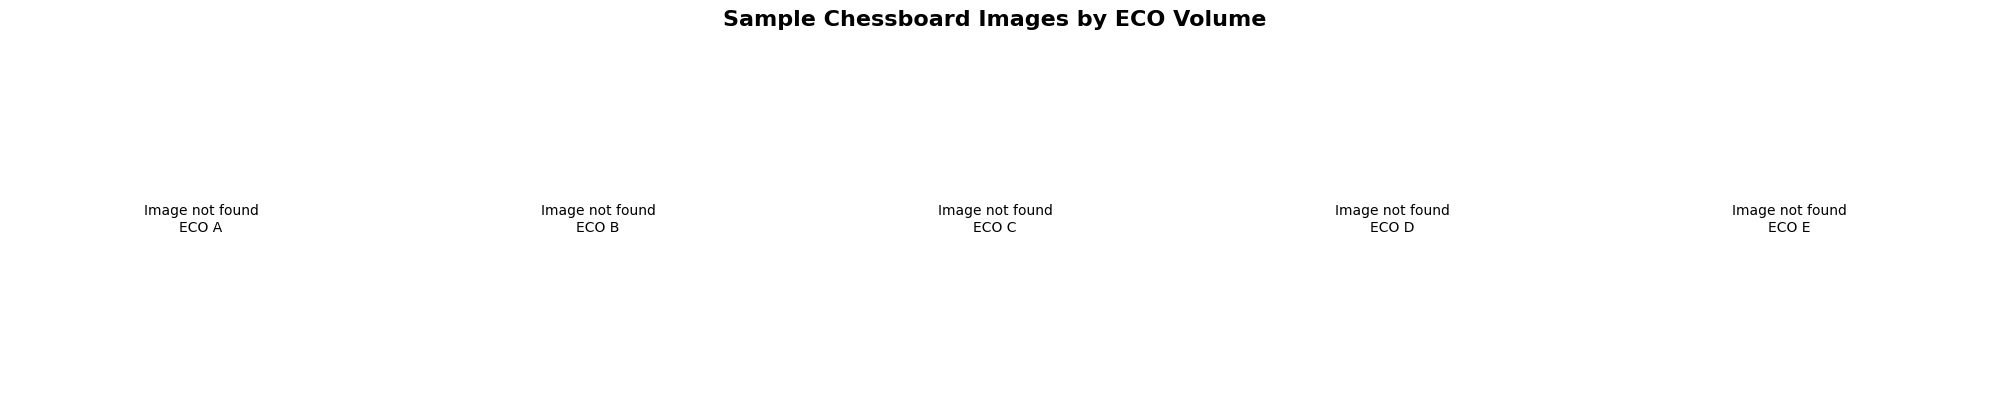

In [12]:
# Display sample images from each ECO volume
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
eco_volumes = sorted(train_df['eco_volume'].unique())

for idx, eco in enumerate(eco_volumes):
    # Get a sample image for this ECO volume
    sample = train_df[train_df['eco_volume'] == eco].iloc[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, sample['image_id'])
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'ECO Volume {eco}\n{sample["opening_name"][:30]}...', 
                           fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'Image not found\nECO {eco}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')

plt.suptitle('Sample Chessboard Images by ECO Volume', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
class ChessECODataset(Dataset):
    def __init__(self, df, images_path, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_path = images_path
        self.transform = transform
        
        # Create label mapping
        self.eco_to_idx = {eco: idx for idx, eco in enumerate(sorted(df['eco_volume'].unique()))}
        self.idx_to_eco = {idx: eco for eco, idx in self.eco_to_idx.items()}
        
        print(f"📋 ECO to Index mapping: {self.eco_to_idx}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        
        # Try to load image with smart extension detection
        img_path = None
        possible_extensions = ['', '.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        for ext in possible_extensions:
            test_path = os.path.join(self.images_path, image_id + ext)
            if os.path.exists(test_path):
                img_path = test_path
                break
        
        if img_path is None:
            print(f"⚠️ Image not found for any extension: {image_id}")
            # Return a blank image as fallback
            image = Image.new('RGB', (224, 224), color='white')
        else:
            try:
                image = Image.open(img_path).convert('RGB')
            except Exception as e:
                print(f"⚠️ Error loading image {img_path}: {e}")
                # Return a blank image as fallback
                image = Image.new('RGB', (224, 224), color='white')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Get label
        label = self.eco_to_idx[row['eco_volume']]
        
        return image, label
    
    def get_class_weights(self):
        """Calculate class weights for handling imbalanced data"""
        eco_counts = self.df['eco_volume'].value_counts()
        total_samples = len(self.df)
        weights = []
        
        for eco in sorted(self.eco_to_idx.keys()):
            weight = total_samples / (len(self.eco_to_idx) * eco_counts[eco])
            weights.append(weight)
        
        return torch.FloatTensor(weights)

print("✅ ChessECODataset class defined")

✅ ChessECODataset class defined


In [14]:
# Dataset validation - Check image files and extensions
def validate_dataset_files(df, images_path, sample_size=10):
    """Validate that image files exist and check their extensions"""
    print(f"🔍 Validating dataset files in: {images_path}")
    
    if not os.path.exists(images_path):
        print(f"❌ Directory does not exist: {images_path}")
        return
    
    # Get all files in directory
    all_files = os.listdir(images_path)
    image_extensions = {}
    
    # Count file extensions
    for file in all_files:
        ext = os.path.splitext(file)[1].lower()
        if ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            image_extensions[ext] = image_extensions.get(ext, 0) + 1
    
    print(f"📁 Total files in directory: {len(all_files)}")
    print(f"🖼️ Image files by extension: {image_extensions}")
    
    # Check a sample of image_ids from DataFrame
    sample_df = df.head(sample_size)
    found_count = 0
    missing_count = 0
    
    print(f"\n🧪 Checking {len(sample_df)} sample image IDs:")
    for idx, row in sample_df.iterrows():
        image_id = row['image_id']
        
        # Try direct path first
        direct_path = os.path.join(images_path, image_id)
        if os.path.exists(direct_path):
            found_count += 1
            print(f"✅ Found: {image_id}")
            continue
        
        # Try with extensions
        found = False
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            ext_path = os.path.join(images_path, image_id + ext)
            if os.path.exists(ext_path):
                found_count += 1
                print(f"✅ Found with extension: {image_id} -> {image_id + ext}")
                found = True
                break
        
        if not found:
            missing_count += 1
            print(f"❌ Missing: {image_id}")
    
    print(f"\n📊 Summary:")
    print(f"  Found: {found_count}/{len(sample_df)}")
    print(f"  Missing: {missing_count}/{len(sample_df)}")
    
    # Show some actual filenames for reference
    print(f"\n📋 Sample actual filenames:")
    for i, file in enumerate(all_files[:5]):
        print(f"  {file}")
    if len(all_files) > 5:
        print(f"  ... and {len(all_files) - 5} more files")

# Validate both training and test datasets
print("🔍 Validating Training Dataset:")
validate_dataset_files(train_df, TRAIN_IMAGES_PATH)

print("\n" + "="*60)
print("🔍 Validating Test Dataset:")
validate_dataset_files(test_df, TEST_IMAGES_PATH)

🔍 Validating Training Dataset:
🔍 Validating dataset files in: /kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/train_images
📁 Total files in directory: 2827
🖼️ Image files by extension: {'.jpg': 2827}

🧪 Checking 10 sample image IDs:
✅ Found with extension: train_00000 -> train_00000.jpg
✅ Found with extension: train_00001 -> train_00001.jpg
✅ Found with extension: train_00002 -> train_00002.jpg
✅ Found with extension: train_00003 -> train_00003.jpg
✅ Found with extension: train_00004 -> train_00004.jpg
✅ Found with extension: train_00005 -> train_00005.jpg
✅ Found with extension: train_00006 -> train_00006.jpg
✅ Found with extension: train_00007 -> train_00007.jpg
✅ Found with extension: train_00008 -> train_00008.jpg
✅ Found with extension: train_00009 -> train_00009.jpg

📊 Summary:
  Found: 10/10
  Missing: 0/10

📋 Sample actual filenames:
  train_00232.jpg
  train_02167.jpg
  train_02204.jpg
  train_00259.jpg
  train_01167.jpg
  ... and 2822 more files

🔍 V

In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Custom chess rotation transform
class ChessRandomRotation:
    """Random rotation by 0, 90, 180, or 270 degrees for chess boards"""
    def __init__(self, p=0.5):
        self.p = p
        self.angles = [0, 90, 180, 270]
    
    def __call__(self, img):
        if torch.rand(1) < self.p:
            angle = int(np.random.choice(self.angles))  # Convert to Python int
            return transforms.functional.rotate(img, angle)
        return img

# Chess-specific data transforms
# Note: Chessboards are symmetric, so we can use horizontal/vertical flips
# Rotations should be limited to 90-degree increments to maintain board orientation

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Larger size for better detail
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop for variation
    transforms.RandomHorizontalFlip(0.5),       # Horizontal flip (valid for chess)
    transforms.RandomVerticalFlip(0.3),         # Vertical flip (less common but valid)
    ChessRandomRotation(p=0.4),                 # Chess-specific 90-degree rotations
    transforms.ColorJitter(
        brightness=0.2,     # Lighting variations
        contrast=0.2,       # Board contrast changes
        saturation=0.1,     # Slight color variations
        hue=0.05           # Minor hue shifts
    ),
    transforms.RandomApply([
        transforms.GaussianBlur(3, sigma=(0.1, 1.0))
    ], p=0.1),  # Occasional blur for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test Time Augmentation transforms
tta_transforms = [
    # Original
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    # Horizontal flip
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    # 180-degree rotation (using functional transform)
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: transforms.functional.rotate(img, 180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
]

print("✅ Data transforms defined with chess-specific augmentations")

🖥️ Using device: cuda
✅ Data transforms defined with chess-specific augmentations


In [16]:
# Create datasets
train_dataset_full = ChessECODataset(train_df, TRAIN_IMAGES_PATH, transform=train_transform)
val_dataset_full = ChessECODataset(train_df, TRAIN_IMAGES_PATH, transform=val_transform)

# Stratified train/validation split
from sklearn.model_selection import train_test_split

# Create stratified split indices
train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['eco_volume'],
    random_state=42
)

# Create subset datasets
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

# Calculate class weights for loss function
class_weights = train_dataset_full.get_class_weights().to(device)

print(f"📊 Training samples: {len(train_dataset)}")
print(f"📊 Validation samples: {len(val_dataset)}")
print(f"⚖️ Class weights: {class_weights.cpu().numpy()}")

# Verify stratification
train_eco_dist = train_df.iloc[train_indices]['eco_volume'].value_counts().sort_index()
val_eco_dist = train_df.iloc[val_indices]['eco_volume'].value_counts().sort_index()

print("\n📈 Training set distribution:")
print(train_eco_dist)
print("\n📈 Validation set distribution:")
print(val_eco_dist)

📋 ECO to Index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
📋 ECO to Index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
📊 Training samples: 2261
📊 Validation samples: 566
⚖️ Class weights: [0.9566836 0.9502521 0.5889583 1.3334906 2.2      ]

📈 Training set distribution:
eco_volume
A    473
B    476
C    768
D    339
E    205
Name: count, dtype: int64

📈 Validation set distribution:
eco_volume
A    118
B    119
C    192
D     85
E     52
Name: count, dtype: int64


In [17]:
# Create data loaders
BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True  # For stable batch normalization
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"🔄 Data loaders created with batch size: {BATCH_SIZE}")
print(f"📦 Training batches: {len(train_loader)}")
print(f"📦 Validation batches: {len(val_loader)}")

🔄 Data loaders created with batch size: 32
📦 Training batches: 70
📦 Validation batches: 18


In [18]:
# Load EfficientNet-B3 model
from torchvision.models import efficientnet_b3

# Load pre-trained model
model = efficientnet_b3(pretrained=True)

# Modify classifier for 5-class chess ECO classification
num_classes = len(train_dataset_full.eco_to_idx)
num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️ Model: EfficientNet-B3")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,}")
print(f"🔢 Number of classes: {num_classes}")
print(f"📝 Classes: {list(train_dataset_full.eco_to_idx.keys())}")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 161MB/s]


🏗️ Model: EfficientNet-B3
📊 Total parameters: 11,615,789
🎯 Trainable parameters: 11,615,789
🔢 Number of classes: 5
📝 Classes: ['A', 'B', 'C', 'D', 'E']


In [19]:
# Loss function with class weights to handle imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer - AdamW with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

# Training parameters
EPOCHS = 30
PATIENCE = 8
SAVE_PATH = 'best_chess_eco_model.pth'

print("⚙️ Training configuration:")
print(f"  📚 Epochs: {EPOCHS}")
print(f"  ⏰ Patience: {PATIENCE}")
print(f"  📈 Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  💾 Model save path: {SAVE_PATH}")
print(f"  🎯 Loss function: CrossEntropyLoss with label smoothing and class weights")

⚙️ Training configuration:
  📚 Epochs: 30
  ⏰ Patience: 8
  📈 Learning rate: 0.001
  💾 Model save path: best_chess_eco_model.pth
  🎯 Loss function: CrossEntropyLoss with label smoothing and class weights


In [20]:
# Reset training state (run this before restarting training)
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
patience_counter = 0

print("🔄 Training state reset successfully!")
print("✅ Ready to start fresh training...")

🔄 Training state reset successfully!
✅ Ready to start fresh training...


In [21]:
# Verify dataset paths before training
import os

print("📍 Checking dataset paths...")
paths_to_check = [
    ('Training images', TRAIN_IMAGES_PATH),
    ('Test images', TEST_IMAGES_PATH),
    ('Training CSV', TRAIN_CSV),
    ('Test CSV', TEST_CSV)
]

all_paths_exist = True
for name, path in paths_to_check:
    if os.path.exists(path):
        if os.path.isdir(path):
            count = len(os.listdir(path))
            print(f"✅ {name}: {path} ({count} files)")
        else:
            print(f"✅ {name}: {path}")
    else:
        print(f"❌ {name}: {path} (NOT FOUND)")
        all_paths_exist = False

if all_paths_exist:
    print("\n🎉 All paths are valid! Ready to proceed with training.")
else:
    print("\n⚠️ Some paths are missing. Please update the file paths in cell 3.")

📍 Checking dataset paths...
✅ Training images: /kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/train_images (2827 files)
✅ Test images: /kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/test_images (707 files)
✅ Training CSV: /kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/train.csv
✅ Test CSV: /kaggle/input/binary-biplob-can-you-guess-the-chess-opening/chess_dataset/test.csv

🎉 All paths are valid! Ready to proceed with training.


In [22]:
# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
patience_counter = 0

print("🚀 Starting training...\n")

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Progress logging
        if batch_idx % 20 == 0:
            print(f'Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_running_loss / len(val_loader)
    
    # Record metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Print epoch results
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Results:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'eco_to_idx': train_dataset_full.eco_to_idx,
            'idx_to_eco': train_dataset_full.idx_to_eco
        }, SAVE_PATH)
        
        print(f"  ✅ New best validation accuracy: {val_acc:.2f}% - Model saved!")
    else:
        patience_counter += 1
        print(f"  ⏰ No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 60)

print(f"\n🎉 Training completed! Best validation accuracy: {best_val_acc:.2f}%")

🚀 Starting training...

Epoch 1/30, Batch 0/70, Loss: 1.6753
Epoch 1/30, Batch 20/70, Loss: 1.6529
Epoch 1/30, Batch 40/70, Loss: 1.5965
Epoch 1/30, Batch 60/70, Loss: 1.7613

📊 Epoch 1/30 Results:
  Train Loss: 1.6176, Train Acc: 24.78%
  Val Loss: 1.5631, Val Acc: 27.03%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 27.03% - Model saved!
------------------------------------------------------------
Epoch 2/30, Batch 0/70, Loss: 1.5693
Epoch 2/30, Batch 20/70, Loss: 1.4948
Epoch 2/30, Batch 40/70, Loss: 1.4530
Epoch 2/30, Batch 60/70, Loss: 1.3970

📊 Epoch 2/30 Results:
  Train Loss: 1.4979, Train Acc: 37.10%
  Val Loss: 1.2788, Val Acc: 53.71%
  Learning Rate: 0.001000
  ✅ New best validation accuracy: 53.71% - Model saved!
------------------------------------------------------------
Epoch 3/30, Batch 0/70, Loss: 1.4157
Epoch 3/30, Batch 20/70, Loss: 1.2888
Epoch 3/30, Batch 40/70, Loss: 1.4554
Epoch 3/30, Batch 60/70, Loss: 1.3395

📊 Epoch 3/30 Results:
  Train Loss: 1.

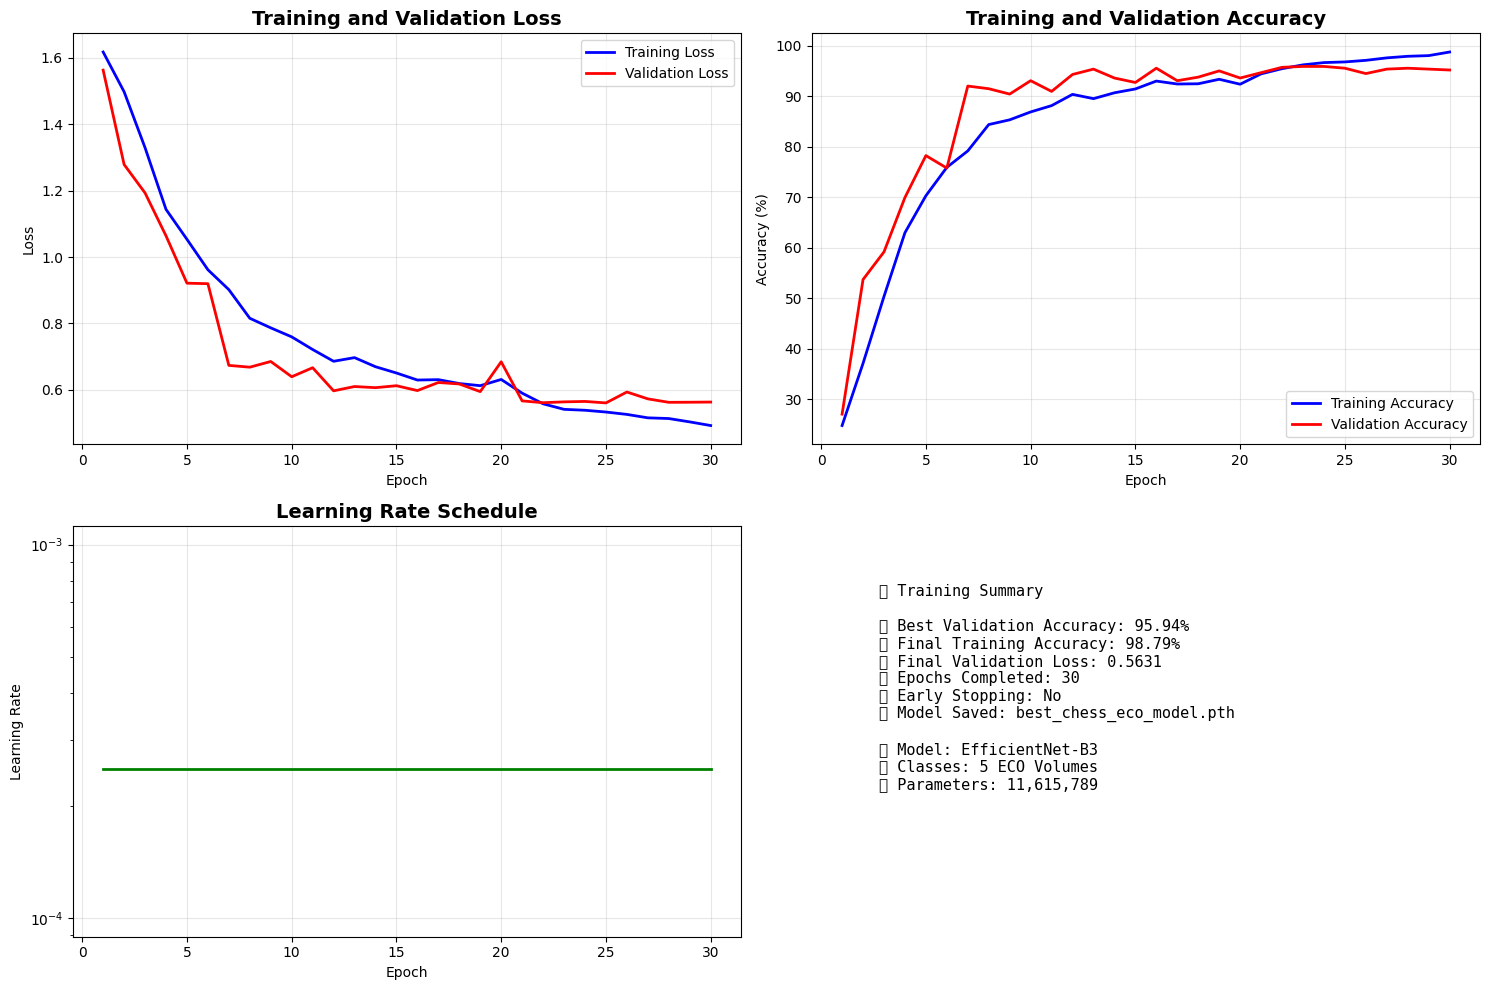

In [23]:
# Plot training progress
epochs_completed = len(train_losses)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
ax1.plot(range(1, epochs_completed + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, epochs_completed + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plots
ax2.plot(range(1, epochs_completed + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, epochs_completed + 1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning rate plot (if available)
ax3.plot(range(1, epochs_completed + 1), [optimizer.param_groups[0]['lr']] * epochs_completed, 'g-', linewidth=2)
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Training summary
ax4.axis('off')
summary_text = f"""
📊 Training Summary

🎯 Best Validation Accuracy: {best_val_acc:.2f}%
📈 Final Training Accuracy: {train_accuracies[-1]:.2f}%
📉 Final Validation Loss: {val_losses[-1]:.4f}
🔄 Epochs Completed: {epochs_completed}
⏰ Early Stopping: {'Yes' if patience_counter >= PATIENCE else 'No'}
💾 Model Saved: {SAVE_PATH}

🏆 Model: EfficientNet-B3
📚 Classes: {num_classes} ECO Volumes
🔢 Parameters: {total_params:,}
"""
ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig('chess_training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Load best model
checkpoint = torch.load(SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Detailed validation evaluation
model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

# Calculate accuracy
accuracy = (all_predictions == all_labels).mean()
print(f"\n🎯 Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

✅ Loaded best model with validation accuracy: 95.94%

🎯 Validation Accuracy: 0.9594 (95.94%)


📋 Classification Report:
              precision    recall  f1-score   support

           A     0.9569    0.9407    0.9487       118
           B     0.9492    0.9412    0.9451       119
           C     0.9844    0.9844    0.9844       192
           D     0.9222    0.9765    0.9486        85
           E     0.9600    0.9231    0.9412        52

    accuracy                         0.9594       566
   macro avg     0.9545    0.9532    0.9536       566
weighted avg     0.9597    0.9594    0.9593       566



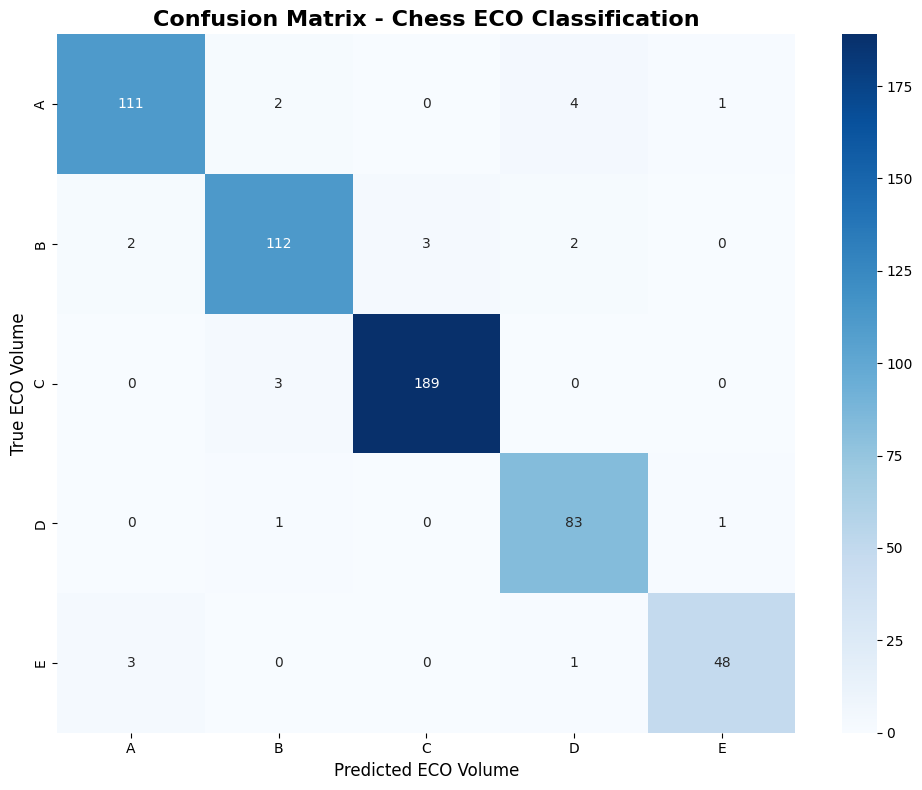


📊 Per-class Accuracies:
  ECO A: 0.9407 (94.07%)
  ECO B: 0.9412 (94.12%)
  ECO C: 0.9844 (98.44%)
  ECO D: 0.9765 (97.65%)
  ECO E: 0.9231 (92.31%)


In [25]:
# Classification report
eco_names = [train_dataset_full.idx_to_eco[i] for i in range(num_classes)]

print("📋 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=eco_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=eco_names, yticklabels=eco_names)
plt.title('Confusion Matrix - Chess ECO Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted ECO Volume', fontsize=12)
plt.ylabel('True ECO Volume', fontsize=12)
plt.tight_layout()
plt.savefig('chess_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\n📊 Per-class Accuracies:")
for i, eco in enumerate(eco_names):
    print(f"  ECO {eco}: {class_accuracies[i]:.4f} ({class_accuracies[i]*100:.2f}%)")

In [30]:
# Create test dataset for TTA
class TestDatasetTTA(Dataset):
    def __init__(self, df, images_path, tta_transforms):
        self.df = df.reset_index(drop=True)
        self.images_path = images_path
        self.tta_transforms = tta_transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        
        # Smart file loading with extension detection
        img_path = None
        possible_extensions = ['', '.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        for ext in possible_extensions:
            test_path = os.path.join(self.images_path, image_id + ext)
            if os.path.exists(test_path):
                img_path = test_path
                break
        
        if img_path is None:
            # If still no valid path found, list available files and try to match
            available_files = os.listdir(self.images_path)
            base_name = os.path.splitext(image_id)[0]  # Remove any existing extension
            
            # Try to find a matching file
            matching_file = None
            for file in available_files:
                if os.path.splitext(file)[0] == base_name:
                    matching_file = file
                    break
            
            if matching_file:
                img_path = os.path.join(self.images_path, matching_file)
        
        # Load the image
        try:
            if img_path and os.path.exists(img_path):
                image = Image.open(img_path).convert('RGB')
            else:
                print(f"⚠️ No image found for {image_id} in {self.images_path}")
                image = Image.new('RGB', (224, 224), color='white')
        except Exception as e:
            print(f"⚠️ Error loading test image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='white')
        
        # Apply all TTA transforms
        tta_images = []
        for transform in self.tta_transforms:
            tta_images.append(transform(image))
        
        return tta_images, row['image_id']

# Create test dataset with TTA
test_dataset_tta = TestDatasetTTA(test_df, TEST_IMAGES_PATH, tta_transforms)
test_loader_tta = DataLoader(test_dataset_tta, batch_size=8, shuffle=False, num_workers=2)

print(f"🧪 Test dataset with TTA created: {len(test_dataset_tta)} samples")
print(f"🔄 Number of TTA transforms: {len(tta_transforms)}")

🧪 Test dataset with TTA created: 707 samples
🔄 Number of TTA transforms: 3


In [31]:
# Inference with Test Time Augmentation
model.eval()
test_results = []

print("🔮 Starting test inference with TTA...")

with torch.no_grad():
    for batch_idx, (tta_images_list, image_ids) in enumerate(test_loader_tta):
        batch_predictions = []
        
        for img_idx in range(len(image_ids)):
            # Collect predictions from all TTA transforms
            tta_predictions = []
            
            for tta_idx in range(len(tta_transforms)):
                img = tta_images_list[tta_idx][img_idx].unsqueeze(0).to(device)
                output = model(img)
                prob = torch.softmax(output, dim=1)
                tta_predictions.append(prob.cpu())
            
            # Average predictions across all TTA transforms
            avg_prediction = torch.mean(torch.stack(tta_predictions), dim=0)
            pred_class = torch.argmax(avg_prediction, dim=1).item()
            confidence = avg_prediction[0][pred_class].item()
            
            # Convert prediction back to ECO volume
            eco_volume = train_dataset_full.idx_to_eco[pred_class]
            
            test_results.append({
                'image_id': image_ids[img_idx],
                'eco_volume': eco_volume,
                'confidence': confidence
            })
        
        if batch_idx % 10 == 0:
            print(f"Processed {batch_idx * test_loader_tta.batch_size}/{len(test_dataset_tta)} images")

print(f"\n✅ Test inference completed! Generated predictions for {len(test_results)} images")

🔮 Starting test inference with TTA...
Processed 0/707 images
Processed 80/707 images
Processed 160/707 images
Processed 240/707 images
Processed 320/707 images
Processed 400/707 images
Processed 480/707 images
Processed 560/707 images
Processed 640/707 images

✅ Test inference completed! Generated predictions for 707 images


In [32]:
# Create submission DataFrame
submission_df = pd.DataFrame(test_results)

# Ensure all test images are included
submission_df = submission_df.merge(test_df[['image_id']], on='image_id', how='right')

# Check for any missing predictions
missing_predictions = submission_df['eco_volume'].isna().sum()
if missing_predictions > 0:
    print(f"⚠️ Warning: {missing_predictions} missing predictions detected")
    # Fill missing predictions with most common class
    most_common_eco = submission_df['eco_volume'].mode()[0]
    submission_df['eco_volume'].fillna(most_common_eco, inplace=True)
    print(f"Filled missing predictions with most common class: {most_common_eco}")

# Create final submission file
final_submission = submission_df[['image_id', 'eco_volume']].copy()
final_submission.to_csv('chess_eco_submission.csv', index=False)

print(f"\n📄 Submission file created: chess_eco_submission.csv")
print(f"📊 Submission shape: {final_submission.shape}")
print(f"\n📈 Prediction distribution:")
print(final_submission['eco_volume'].value_counts().sort_index())

# Display sample predictions
print(f"\n🔍 Sample predictions:")
sample_with_confidence = submission_df[['image_id', 'eco_volume', 'confidence']].head(10)
print(sample_with_confidence.to_string(index=False))

print(f"\n✅ Ready for submission!")
print(f"📋 Final validation accuracy: {best_val_acc:.2f}%")
print(f"🎯 Model: EfficientNet-B3 with TTA")
print(f"📁 Submission file: chess_eco_submission.csv")


📄 Submission file created: chess_eco_submission.csv
📊 Submission shape: (707, 2)

📈 Prediction distribution:
eco_volume
A    144
B    146
C    241
D    113
E     63
Name: count, dtype: int64

🔍 Sample predictions:
  image_id eco_volume  confidence
test_00000          C    0.795325
test_00001          C    0.829750
test_00002          B    0.874810
test_00003          C    0.838758
test_00004          A    0.914237
test_00005          E    0.956591
test_00006          A    0.909526
test_00007          D    0.951041
test_00008          E    0.768617
test_00009          D    0.937980

✅ Ready for submission!
📋 Final validation accuracy: 95.94%
🎯 Model: EfficientNet-B3 with TTA
📁 Submission file: chess_eco_submission.csv


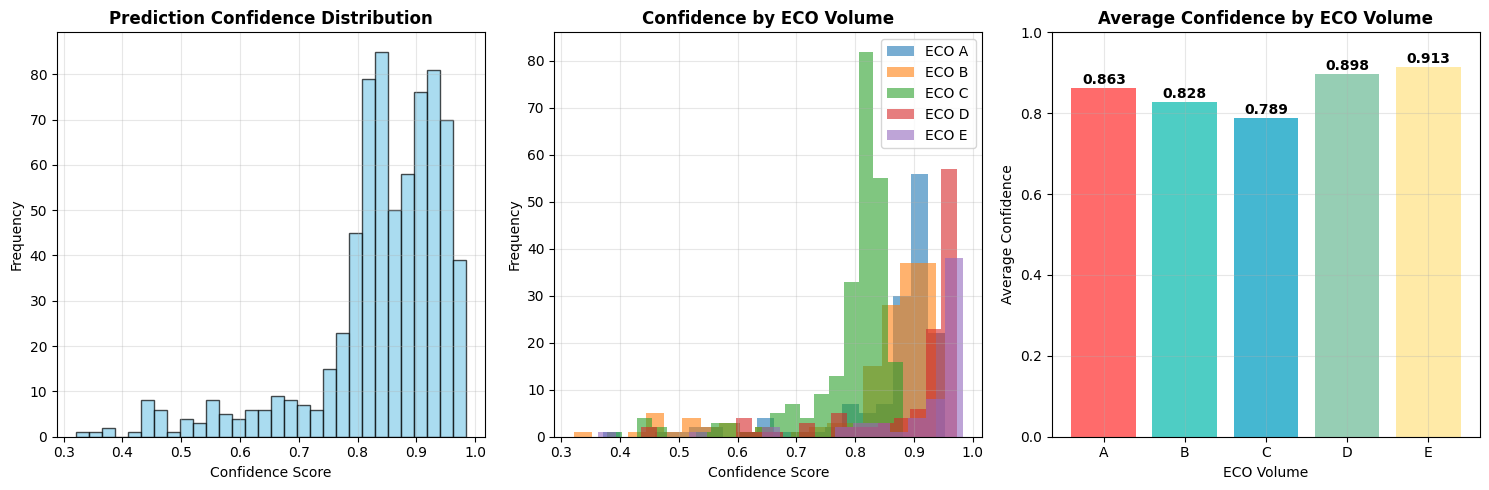

📊 Confidence Statistics:
  Mean confidence: 0.8406
  Median confidence: 0.8591
  Min confidence: 0.3217
  Max confidence: 0.9835
  Std confidence: 0.1157

🎯 High confidence predictions (>0.9): 253 (35.8%)
⚠️ Low confidence predictions (<0.5): 20 (2.8%)


In [33]:
# Confidence distribution analysis
plt.figure(figsize=(15, 5))

# Overall confidence distribution
plt.subplot(1, 3, 1)
plt.hist(submission_df['confidence'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Prediction Confidence Distribution', fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Confidence by ECO volume
plt.subplot(1, 3, 2)
for eco in sorted(submission_df['eco_volume'].dropna().unique()):
    eco_confidences = submission_df[submission_df['eco_volume'] == eco]['confidence'].dropna()
    plt.hist(eco_confidences, alpha=0.6, label=f'ECO {eco}', bins=20)
plt.title('Confidence by ECO Volume', fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Average confidence by ECO volume
plt.subplot(1, 3, 3)
avg_confidence = submission_df.groupby('eco_volume')['confidence'].mean().sort_index()
bars = plt.bar(avg_confidence.index, avg_confidence.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.title('Average Confidence by ECO Volume', fontweight='bold')
plt.xlabel('ECO Volume')
plt.ylabel('Average Confidence')
plt.ylim(0, 1)

# Add value labels on bars
for bar, val in zip(bars, avg_confidence.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('chess_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("📊 Confidence Statistics:")
print(f"  Mean confidence: {submission_df['confidence'].mean():.4f}")
print(f"  Median confidence: {submission_df['confidence'].median():.4f}")
print(f"  Min confidence: {submission_df['confidence'].min():.4f}")
print(f"  Max confidence: {submission_df['confidence'].max():.4f}")
print(f"  Std confidence: {submission_df['confidence'].std():.4f}")

# High confidence predictions
high_conf_threshold = 0.9
high_conf_predictions = submission_df[submission_df['confidence'] > high_conf_threshold]
print(f"\n🎯 High confidence predictions (>{high_conf_threshold}): {len(high_conf_predictions)} ({len(high_conf_predictions)/len(submission_df)*100:.1f}%)")

# Low confidence predictions
low_conf_threshold = 0.5
low_conf_predictions = submission_df[submission_df['confidence'] < low_conf_threshold]
print(f"⚠️ Low confidence predictions (<{low_conf_threshold}): {len(low_conf_predictions)} ({len(low_conf_predictions)/len(submission_df)*100:.1f}%)")